# S&P 500 Stock Clustering

This notebook demonstrates a clustering of the S&P 500 stock exchange, based on a select set of financial figures

The exchange consists of 500 companies, but includes 505 common stocks, due to 5 companies having two shares of stocks in the exchange (Facebook, Under-Armour, NewsCorp, Comcast and 21st Century Fox)

In [165]:
# libraries for making requests and parsing HTML
import requests
from bs4 import BeautifulSoup

# plotting
import matplotlib.pyplot as plt

# sklearn for kmeans and model metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score

# pandas, for data wrangling
import pandas as pd

# Data Accquisition

For the data I wanted access to, the existing APIs for financial data did not work out. Instead. I decided to manually scrape the data, ussing Wikipedia and Yahoo Finance.

1. scrape the list of S&P 500 tickers from Wikipedia
2. scrape the financial figures for each stock ticker from Yahoo Finance

In [2]:
# URL to get S&P tickers from
TICKER_URL = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# multi-level identifier, to select each row of ticker table in HTML response
TABLE_IDENTIFIER = '#constituents tbody tr td'

# yahoo finance URL we can use to scrape data for each company
YAHOO_URL = 'http://finance.yahoo.com/quote/'

# HTML classes for various elements on yahoo finance page

YAHOO_TABLE_CLASS = 'Ta(end) Fw(600) Lh(14px)'
# EPS (TTM) react-id
# Open price react-id
# Div/Yield react-id
YAHOO_IDS = ['OPEN-value', 'EPS_RATIO-value', 'DIVIDEND_AND_YIELD-value', 'PE_RATIO-value']

In [3]:
# get HTML content from wikipedia S&P 500 page
res = BeautifulSoup(requests.get(TICKER_URL).text, 'html.parser')

In [4]:
# get the table of stock ticker data, selecting on TABLE_ID
table_data = [ticker for ticker in res.select(TABLE_IDENTIFIER)]

In [5]:
# iterate over each row of table (9 elements of information), and extract the individual tickers
tickers = [table_data[i].text for i in range(0, len(table_data), 9)]

In [409]:
# iterate through the S&P 500 company tickers, and collect data from Yahoo Finance
def get_yahoo_ticker_data(tickers):
    ticker_data = []
    # make GET request for specified ticker
    print(len(tickers))
    for i, ticker in enumerate(tickers):
        print(i)
        try:
            REQ_URL = YAHOO_URL + ticker[:-1] + '?p=' + ticker[:-1]
            ticker_i_res = requests.get(REQ_URL)
            ticker_i_parser = BeautifulSoup(ticker_i_res.text, 'html.parser')

            ticker_i_data = [ticker[:-1]]
            ticker_i_open_eps_div = [ticker_i_parser.find(attrs={'class': YAHOO_TABLE_CLASS, 'data-test': id_}).text for id_ in YAHOO_IDS]
            for data in ticker_i_open_eps_div:
                    ticker_i_data.append(data)
            ticker_data.append(ticker_i_data)
        except:
            print("error for " + ticker)
            continue
    return ticker_data

# Saving the data

The process of scraping all of the necessary data was rather cumbersome, so it made sense to save the data to file for future experiments

In [487]:
# convert yahoo finance data to dataframe

# will include:
# EPS (TTM) => earnings per share for trailing 12 months
# Dividend/Yield => dividend per share / price per share
# P/E ratio => share price / earnings per share
try:
    df = pd.read_csv('data.csv')
except:
    # iterate over stock tickers, and get 1 year of time-series data
    market_data = pd.DataFrame()
    yahoo_data = get_yahoo_ticker_data(tickers)
    df = pd.DataFrame(yahoo_data, columns=['ticker', 'open', 'eps', 'div'])#, 'pe'],)
    df.to_csv(path_or_buf='data.csv')
df.head()

,Unnamed: 0,ticker,open,eps,div
0,0,MMM,169.78,8.43,5.76 (3.39%)
1,1,ABT,87.08,1.84,1.44 (1.65%)
2,2,ABBV,90.05,2.18,4.72 (5.24%)
3,3,ABMD,179.85,4.79,N/A (N/A)
4,4,ACN,203.60,7.36,3.72 (1.83%)


In [488]:
df['div'] = df['div'].replace({'N/A (N/A)': 0})

# Preprocessing

Some data preprocessing is required before proceeding forward with experimentation

1. separating percentage dividend yield and dividend yield amount into two separate featuress
2. reformatting some features into representations that could be converted to numerical types
3. casting features of DataFrame to numerical types

In [489]:
# drop NaN values
df = df.dropna()

# remove NaN values that aren't using NaN value
df = df[df['eps'] != 'N/A']
df['eps'] = df['eps'].astype(float)


# preprocess open values
df['open'] = df['open'].astype(str)
df['open'] = df['open'].apply(lambda x: x.replace(',', '')).astype(float)

# split dividend into amount and percentage
df['div'] = df['div'].astype(str)
df['div_pct'] = df['div'].apply(lambda x: x.split(' ')[1] if len(x.split(' ')) > 1 else '(0%)')
df['div_pct'] = df['div_pct'].apply(lambda x: x[1:-2]).astype(float)
df['div_amt'] = df['div'].apply(lambda x: x.split(' ')[0]).astype(float)
df = df.drop(['div'], axis=1)
df.isnull().sum()

/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Unnamed: 0    0
ticker        0
open          0
eps           0
div_pct       0
div_amt       0
dtype: int64

In [490]:
# relevant data for now, will be using these columns for k-means clustering
two_dim_cluster_data = df[['ticker', 'eps', 'div_pct']]
four_dim_cluster_data = df[['ticker', 'eps', 'open', 'div_pct', 'div_amt']]

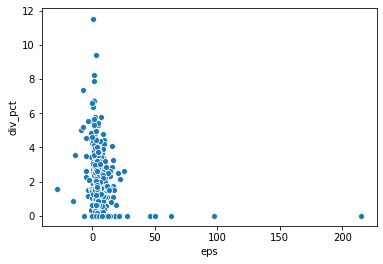

In [491]:
sns.scatterplot(x='eps', y='div_pct', data=two_dim_cluster_data)

# Clustering the data: The K-Means algorithm

Now that the data the accquisition and preprocessing was complete, the next step is clustering our stock data, analyzing the performance of the clustering, based on the number of centroids, and then generating a final clustering based on some performance metrics.

The K-means algorithm operates as follows:

    1. a number of "centroids" are randomly initialized (the number of hyperparameter of the model), these centroid
       match the dimension of the feature set, and can be imagine as a vector into some n-dimensional space
    2. every sample in the data set is then compared to each of the randomly initialized centroids, to see how far 
       it is away from the centroid. Since the samples and centroids are vectors, the distance 
       between a vector v and a centroid u is the vector normal of the difference between the two vectors 
       ((u1-v1)^2 + (u2-v2)^2 + ....)^(1/2). Each sample is then "clustered" with the centroid it is closest to.
    3. After each sample has been clustered with a specific centroid, each centroid is repositioned, such that it
       is the average of all of the samples that have been clustered with it.
    4. The sample association and centroid repositioning steps are then repeated for some number of iterations

In [492]:
# iterate over a variety of amounts of cluster centroids for clustering our stock data
# looking for an "elbow" in the sum of squared error plot, for different amounts of centroids
def k_means_func(data, max_centroids=25):
    # transform numerical features (eps and percentage dividend)
    transform_data = RobustScaler().fit_transform(data.iloc[:,1:])
    
    sum_square_err = {}
    sil_score = {}
    for num_centroids in range(2,max_centroids):
        model = KMeans(n_clusters=num_centroids, random_state=2, n_init=10)
        model.fit(transform_data)
        sum_square_err[num_centroids] = model.inertia_
        sil_score[num_centroids] = silhouette_score(transform_data, model.labels_, random_state=2)
    
    plt.figure(figsize=(16,6))
    ax1 = plt.subplot(211)
    plt.plot(list(sum_square_err.keys()), list(sum_square_err.values()))
    ax1.title.set_text("k-means sum squared error")
    plt.xlabel("num. centroids")
    plt.ylabel("sum squared error")
    plt.xticks([i for i in range(2, max_centroids)])
    
    ax2 = plt.subplot(212)
    plt.plot(list(sil_score.keys()), list(sil_score.values()))
    ax2.title.set_text("k-means silhouette score")
    plt.xlabel("num. centroids")
    plt.ylabel("score")
    plt.xticks([i for i in range(2, max_centroids)])
    plt.yticks([i / 10 for i in range(10)])

# Measuring the performance of K-Means clustering

The K-means algorithm cannot be measured in performance in the same way as supervised learning algorithms. There is no prediction error, since the data we are given is unlabeled, and instead, we measure the performance of the k-means algorithm based on the ability of the chosen number of centroids to effectively cluster the data. Notely, one of the common metrics for K-means is measuring the squared sum of errors between each sample and the centroid it is clustered with, where the squared error is just the squared vector normal of the difference between the sample and the centroid

In addition to the squared sum of errors, K-means is often measured using the silhouette score. This metric is the mean of the silhouette coefficient for every sample. The silhouette coefficient can be defined as follows:

* for a sample S, we define A(S) as the mean distance between S and every other element in S's assigned cluster
* we define B(S) as the mean distance between S, and every point in the closest cluster to S, other than S's assigned cluster
* we define SC(S), the silhouette coefficient, as the difference between A(S) and B(S), divided by the larger of A(S) and B(S)
* therefore, SC(S) ranges from 0 to 1, where SC(S) = 1 means the mean distance from S to every point in S's cluster is 0, and SC(S) = 0 means that the mean distance from S to every point in its cluster is the same as the mean distance from S to every point in the nearest other cluster

Below, we plot these metrics for our application of K-means to the stock data, we can see the following:

1. The silhouette score drops rather quickly after n grows greater than 3-4, this implies that a small amount of clusters most likely results in a few disparate clusters (with a single cluster comprising much of the data)
2. The silhouette score stabilizes after it drops to ~0.4, while the SSE continues to drop rapidly until n~10
3. The silhouette score bumps up slightly for a few values of n (n = 11, n = 15, n = 20), these are likely good values 
   for n, since the silhouette score is stable but slightly up, while the SSE continues to go down 

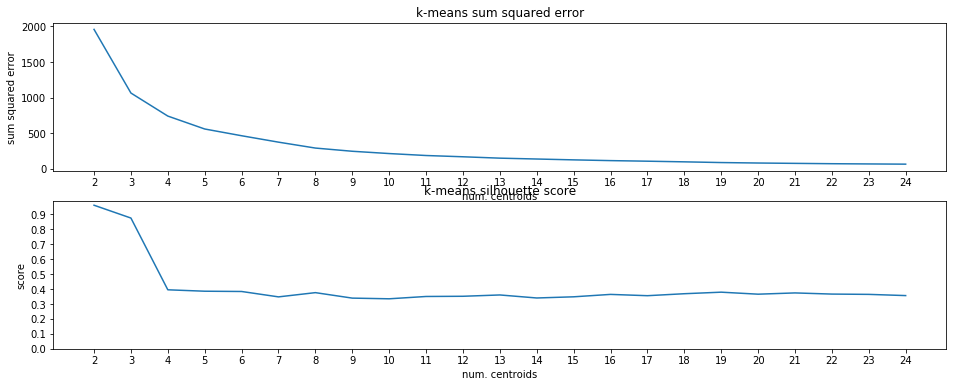

In [493]:
k_means_func(two_dim_cluster_data)

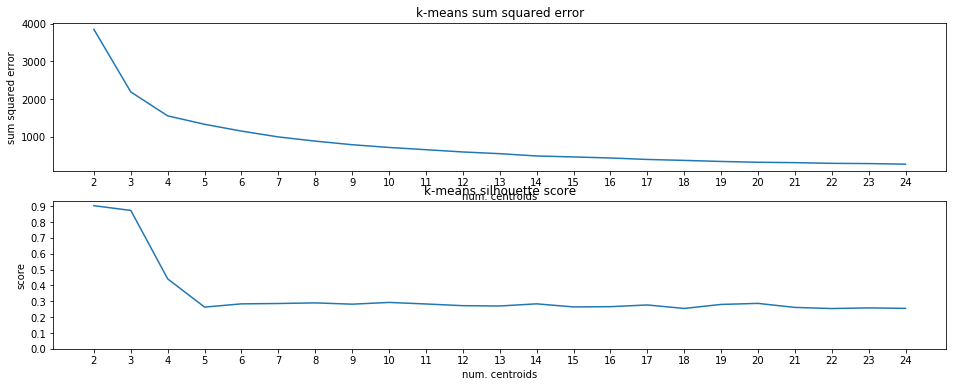

In [494]:
k_means_func(four_dim_cluster_data)    

# Finalizing our clusterings

Given that we have identified a few values for our centroid hyperparameter that seem fruitful, the next step is to fit and cluster the data for these specified values, our results will not be predictions of an output variable, as
is the case in supervised learning, but rather, predictions of certain groupings of our stock tickers

In [495]:
def classify_four_dim_stocks(data, cluster_configs):
    transform_data = RobustScaler().fit_transform(data.iloc[:,1:])
    # initialize K-means models with each of the specified cluster hyperparameter valuess
    for config in cluster_configs.keys():
        model = KMeans(n_clusters=cluster_configs[config], random_state=5, n_init=10)
        model.fit(transform_data)
        data[config] = model.labels_
    return data

In [496]:
cluster_config = {
    'cluster_five': 5,
    'cluster_ten': 10,
    'cluster_fourteen': 14,
    'cluster_twenty': 20
}
four_dim_cluster_data = classify_four_dim_stocks(four_dim_cluster_data[['ticker', 'eps', 'open', 'div_pct', 'div_amt']], cluster_config)

In [497]:
four_dim_cluster_data

,ticker,eps,open,div_pct,div_amt,cluster_five,cluster_ten,cluster_fourteen,cluster_twenty
0,MMM,8.43,169.78,3.39,5.76,4,3,6,17
1,ABT,1.84,87.08,1.65,1.44,3,0,2,9
2,ABBV,2.18,90.05,5.24,4.72,0,9,9,6
3,ABMD,4.79,179.85,0.00,0.00,3,7,12,0
4,ACN,7.36,203.60,1.83,3.72,4,6,6,17
...,...,...,...,...,...,...,...,...,...
499,XYL,2.80,78.10,1.23,0.96,3,0,2,2
500,YUM,3.62,99.48,1.69,1.68,3,0,11,9
501,ZBH,-0.44,149.90,0.64,0.96,3,0,2,2
502,ZION,4.27,51.60,2.64,1.36,0,6,9,13


In [498]:
def output_cluster_tickers(original_data, cluster_data, cluster, show_tickers=[]): 
    for i in range(0, max(cluster_data[cluster])):
        # list of tickers for the current cluster
        ticker_list = list(cluster_data[cluster_data[cluster] == i]['ticker'])
        print("cluster " + str(i) + ":")
        print("includes " + str(len(ticker_list)) + " stocks")
        if(i in show_tickers):
            print(ticker_list)
        # original data for tickers that are part of cluster, more useful than
        # the transformed data
        curr_data = original_data[original_data['ticker'].isin(ticker_list)]
        print(curr_data[['open', 'div_pct', 'div_amt', 'eps']].mean())
        print()

In [499]:
output_clusters(df, four_dim_cluster_data, 'cluster_twenty')

cluster 0:
includes 28 stocks
open       150.557500
div_pct      0.282143
div_amt      0.350357
eps          7.986429
dtype: float64

cluster 1:
includes 1 stocks
open       3820.00
div_pct       0.00
div_amt       0.00
eps         215.31
dtype: float64

cluster 2:
includes 101 stocks
open       64.763663
div_pct     0.686238
div_amt     0.360495
eps         2.357624
dtype: float64

cluster 3:
includes 1 stocks
open       2008.67
div_pct       0.00
div_amt       0.00
eps          97.36
dtype: float64

cluster 4:
includes 1 stocks
open       1795.02
div_pct       0.00
div_amt       0.00
eps          22.57
dtype: float64

cluster 5:
includes 22 stocks
open       27.763636
div_pct     6.433636
div_amt     1.762727
eps         0.315455
dtype: float64

cluster 6:
includes 43 stocks
open       102.298837
div_pct      3.685349
div_amt      3.637209
eps          4.666047
dtype: float64

cluster 7:
includes 5 stocks
open       346.014
div_pct      0.120
div_amt      0.440
eps         20.878
dty

# Changing our approach: The Wealthy Investor technique

I don't have too much expertise with stock trading, but have been listening to a podcast lately called *trading stocks made easy* by Tyrone Jackson (great podcast that I'd reccomend to anyone trying to learn more). He heavily advocates for stocks which pay out a dividend, a portion of their profits that isn't reinvested into the company, but rather goes to the shareholders. Additonally, he advocates for stocks that have sshowed consistent quarterly earnings growth. Between the two, dividend yield is a part of the data that has been collected, so I decided to cluster the subset of data for stocks which do pay out a dividend

In [500]:
# get stocks which pay dividend
div_yielding_data = four_dim_cluster_data[four_dim_cluster_data['div_amt'] > 0]

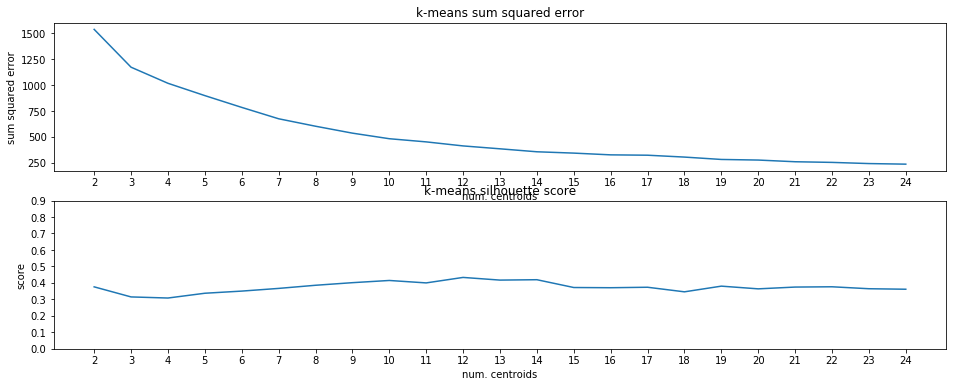

In [501]:
k_means_func(data=div_yielding_data)

In [502]:
# apply model for n = {12, 14, 19}
cluster_config = {
    'cluster_twelve': 12,
    'cluster_fourteen': 14,
    'cluster_nineteen': 19
}
div_yielding_data = classify_four_dim_stocks(div_yielding_data, cluster_config)

/anaconda3/envs/machine_learning/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/anaconda3/envs/machine_learning/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/anaconda3/envs/machine_learning/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [513]:
output_clusters(original_data=df, cluster_data=div_yielding_data, cluster='cluster_twenty')

cluster 0:
includes 13 stocks
open       132.898462
div_pct      0.607692
div_amt      0.754615
eps          7.920769
dtype: float64

cluster 1:
includes 0 stocks
open      NaN
div_pct   NaN
div_amt   NaN
eps       NaN
dtype: float64

cluster 2:
includes 62 stocks
open       56.385484
div_pct     1.117903
div_amt     0.587258
eps         2.474677
dtype: float64

cluster 3:
includes 0 stocks
open      NaN
div_pct   NaN
div_amt   NaN
eps       NaN
dtype: float64

cluster 4:
includes 0 stocks
open      NaN
div_pct   NaN
div_amt   NaN
eps       NaN
dtype: float64

cluster 5:
includes 22 stocks
open       27.763636
div_pct     6.433636
div_amt     1.762727
eps         0.315455
dtype: float64

cluster 6:
includes 43 stocks
open       102.298837
div_pct      3.685349
div_amt      3.637209
eps          4.666047
dtype: float64

cluster 7:
includes 1 stocks
open       363.92
div_pct      0.60
div_amt      2.20
eps         18.78
dtype: float64

cluster 8:
includes 0 stocks
open      NaN
div_pct  

In [504]:
div_yielding_agg = div_yielding_data.drop(columns=['cluster_five', 'cluster_ten', 'cluster_fourteen'], axis=1).groupby('cluster_twenty').mean()

In [505]:
div_yielding_agg

,eps,open,div_pct,div_amt,cluster_twelve,cluster_nineteen
cluster_twenty,,,,,,
0,7.920769,132.898462,0.607692,0.754615,4.538462,15.000000
2,2.474677,56.385484,1.117903,0.587258,2.000000,2.000000
5,0.315455,27.763636,6.433636,1.762727,8.727273,13.818182
6,4.666047,102.298837,3.685349,3.637209,3.046512,10.395349
7,18.780000,363.920000,0.600000,2.200000,6.000000,1.000000
9,4.571294,117.334706,1.622118,1.808706,5.882353,9.317647
10,15.101429,250.187857,2.015714,4.734286,6.285714,1.928571
11,14.860000,579.730000,0.780000,4.520000,6.000000,1.000000
12,-27.980000,190.500000,1.560000,2.960000,7.000000,17.000000


# Plotting the results

Finally! We have some simple visualization of the aggregated data for our clustered dividend yielding S&P 500 stocks. Based on these plots, I'm going to take a closer look at a few of the clusters:

1. cluster 14: this cluster has the highest earnings per share on average of all clusters
2. cluster 18: This cluster (along with the aforementioned cluster 14) has one of highest average dividend
   amounts per share of any cluster
3. cluster 5: this cluster by far has the highest percentage dividend of any cluster

Although open value was included in the feature set (with the intention of clustering stocks based on similar cost per share), open value for an arbritrary day does not seem like a good feature to indicate a specific cluster to consider more carefully

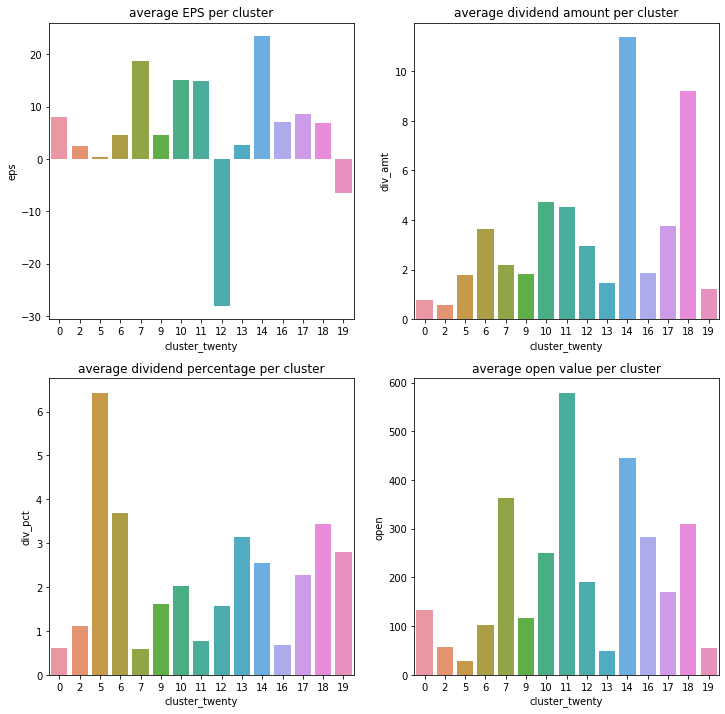

In [511]:
plt.figure(figsize=(12,12))
ax1 = plt.subplot(221)
ax1.title.set_text('average EPS per cluster')
sns.barplot(x=div_yielding_agg.index, y=div_yielding_agg.eps)
ax2 = plt.subplot(222)
ax2.title.set_text('average dividend amount per cluster')
sns.barplot(x=div_yielding_agg.index, y=div_yielding_agg.div_amt)
ax3 = plt.subplot(223)
ax3.title.set_text('average dividend percentage per cluster')
sns.barplot(x=div_yielding_agg.index, y=div_yielding_agg.div_pct)
ax4 = plt.subplot(224)
ax4.title.set_text('average open value per cluster')
sns.barplot(x=div_yielding_agg.index, y=div_yielding_agg.open)

In [512]:
# we can use the output cluster tickers function, passsing an optional parameter which specifies
# which clusters to show the tickers for.
output_cluster_tickers(original_data=df, cluster_data=div_yielding_data, cluster='cluster_twenty', show_tickers=[5, 14, 18])

cluster 0:
includes 13 stocks
open       132.898462
div_pct      0.607692
div_amt      0.754615
eps          7.920769
dtype: float64

cluster 1:
includes 0 stocks
open      NaN
div_pct   NaN
div_amt   NaN
eps       NaN
dtype: float64

cluster 2:
includes 62 stocks
open       56.385484
div_pct     1.117903
div_amt     0.587258
eps         2.474677
dtype: float64

cluster 3:
includes 0 stocks
open      NaN
div_pct   NaN
div_amt   NaN
eps       NaN
dtype: float64

cluster 4:
includes 0 stocks
open      NaN
div_pct   NaN
div_amt   NaN
eps       NaN
dtype: float64

cluster 5:
includes 22 stocks
['MO', 'APA', 'T', 'CTL', 'DOW', 'F', 'GPS', 'HP', 'IVZ', 'IRM', 'KIM', 'KMI', 'LB', 'MAC', 'M', 'NWL', 'NLSN', 'OXY', 'TPR', 'VTR', 'WY', 'WMB']
open       27.763636
div_pct     6.433636
div_amt     1.762727
eps         0.315455
dtype: float64

cluster 6:
includes 43 stocks
open       102.298837
div_pct      3.685349
div_amt      3.637209
eps          4.666047
dtype: float64

cluster 7:
includes 1 s

# Results

Although these results are far from finished, and I will need to comb through financial figures and track these
stocks for more than just one day, it is clear that clustering through the K-means algorithm has allowed me to hone
initial search for potentially lucrative S&P 500 stocks. This was a fun and quick 1-day venture that allowed me to
get more familiar with relevant financial figures for stock trading, scraping stock data, and applying machine
learning techniques to an interesting data set

*cluster five*:
1. MO
2. APA
3. T
4. CTL
5. DOW
6. F
7. GPS
8. HP
9. IVZ
10. IRM
11. KIM
12. KMI
13. LB
14. MAC
15. M
16. NWL
17. NLSN
18. OXY
19. TPR
20. VTR
21. WY
22. WMB

*cluster fourteen*:
1. BLK
2. LMT

*cluster eighteen:
1. BA
2. AVGO
3. EQIX
4. ESS
5. PSA
6. SPG